In [2]:
## Importamos los paquetes a utilizar
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
## Vamos a la base y se crea (en principio sin oversampling)
df = pd.read_csv('base.csv')
df.drop(['Unnamed: 0','spotifyID'], axis=1, inplace = True)
y = df['hit']
X = df.drop(['hit'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [4]:
model = LogisticRegression(C=1e10)
model.fit(X_train,y_train)

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [5]:
y_pred = model.predict(X_test)

In [6]:
roc_auc_score(y_test,y_pred)

0.5

In [7]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      7026
          1       0.00      0.00      0.00       105

avg / total       0.97      0.99      0.98      7131



/Users/chango/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SMOTE

La influencia que posee el desbalanceo es importante. Se repetirá el análisis con Oversampling

In [8]:
sm = SMOTE(random_state=1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [9]:
model.fit(X_train_res,y_train_res)

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [10]:
y_pred = model.predict(X_test)
roc_auc_score(y_test,y_pred)

0.6405900532715222

In [11]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.99      0.57      0.72      7026
          1       0.02      0.71      0.05       105

avg / total       0.98      0.57      0.71      7131



In [12]:
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[3983 3043]
 [  30   75]]


En las filas están representados los datos observados (`y_test`). En las columnas se representan los datos predichos por el modelo (`y_pred`).

** Matriz de confusión **

|                        | Pred Stay ($y\_pred=0$)| Pred Left ($y\_pred=1$)| Total|
| :--------------------  |:----------------------:| :---------------------:|-----:|
| Obs Stay ($y\_test=0$) | 3983                   | 3043                   |7026  |
| Obs Left ($y\_test=1$) | 30                     | 75                     |105   | 
| Total                  | 4013                   | 3118                   |N=7131|
     
Ahora bien, cada casilla aporta información sobre la performace del clasificador:

In [13]:
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [14]:
print('True Positives (TP): hemos predicho correctamente que se trata de un  HIT:',TP)
print('True Negatives (TN): hemos predicho correctamente que NO se trata de un HIT:',TN)
print('False Positives (FP): hemos predicho que el tema era un HIT pero no lo es:',FP)
print('False Negatives (FN): hemos predicho que el tema NO era un HIT pero si lo era:',FN)

True Positives (TP): hemos predicho correctamente que se trata de un  HIT: 75
True Negatives (TN): hemos predicho correctamente que NO se trata de un HIT: 3983
False Positives (FP): hemos predicho que el tema era un HIT pero no lo es: 3043
False Negatives (FN): hemos predicho que el tema NO era un HIT pero si lo era: 30


### Métricas computadas desde la matriz de confusión:

In [15]:
print('Classificator Error:')
print('El error total cometido por el clasificador fue de:',1 - accuracy_score(y_test, y_pred))
print(' ')
print('Recall Score:')
print('Del total de canciones que son HIT, el modelo logra clasificar correctamente un:',recall_score(y_test, y_pred))
print(' ')
print('Precision Score:')
print('De la cantidad de veces que nuestro clasificador predijo que se trataba de un HIT,')
print('la frecuencia que esa predicción fue correcta es de:',precision_score(y_test, y_pred))
print(' ')
print('f1 Score')
print('El promedio armónico entre precision y recall fue de:',f1_score(y_test,y_pred))

Classificator Error:
El error total cometido por el clasificador fue de: 0.4309353526854579
 
Recall Score:
Del total de canciones que son HIT, el modelo logra clasificar correctamente un: 0.7142857142857143
 
Precision Score:
De la cantidad de veces que nuestro clasificador predijo que se trataba de un HIT,
la frecuencia que esa predicción fue correcta es de: 0.024053880692751765
 
f1 Score
El promedio armónico entre precision y recall fue de: 0.04654049022649706


### Ajustando los umbrales

Se presupone que para nosotros es mejor decir que era un HIT cuando no lo era que perder la posibilidad de predicción de un HIT.

In [16]:
model.predict_proba(X_test)

array([[0.41209636, 0.58790364],
       [0.37445139, 0.62554861],
       [0.52443167, 0.47556833],
       ...,
       [0.53421653, 0.46578347],
       [0.4181187 , 0.5818813 ],
       [0.61789548, 0.38210452]])

In [17]:
print(np.mean(model.predict_proba(X_test)[:,1] > 0.5))
print(np.mean(model.predict(X_test)))

y_pred_orig = model.predict(X_test)

0.4372458280746038
0.4372458280746038


In [18]:
y_probs_logit = model.predict_proba(X_test)
y_probs_logit_left = y_probs_logit[:,1]

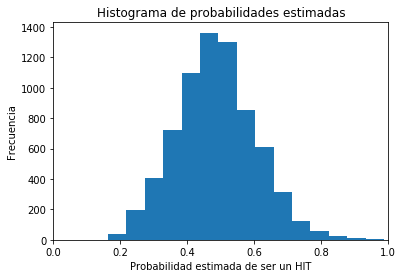

In [19]:
# 15 bins
plt.hist(y_probs_logit_left, bins=15)

# x-axis de 0 a 1
plt.xlim(0,1)
plt.title('Histograma de probabilidades estimadas')
plt.xlabel('Probabilidad estimada de ser un HIT')
plt.ylabel('Frecuencia')
plt.show()

### Curvas `ROC` y área bajo la curva (`AUC`)

In [20]:
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_probs_logit[:,1])

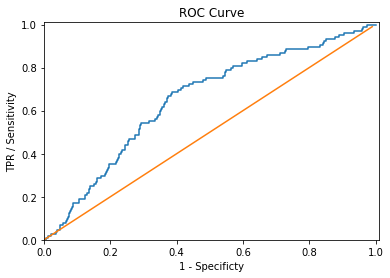

In [21]:
df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

#### Area bajo la curva ROC

In [22]:
print('AUC=', auc(fpr_log, tpr_log))

AUC= 0.6487617421007686


Sobre la base del area bajo la curva ROC se puede decir que el modelo es *regular* dado que se encuentra entre (0.6, 0.75).

## Class Weights para balancear

In [23]:
model = LogisticRegression(C=1e10, class_weight = 'balanced')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
roc_auc_score(y_test,y_pred)

0.6572607864665935

In [24]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.99      0.63      0.77      7026
          1       0.03      0.69      0.05       105

avg / total       0.98      0.63      0.76      7131



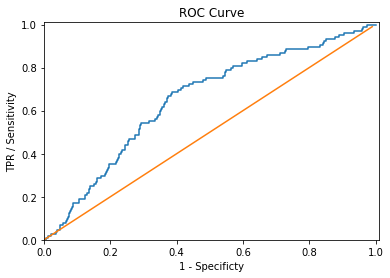

In [25]:
y_probs_logit = model.predict_proba(X_test)
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_probs_logit[:,1])


plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [26]:
print('AUC=', auc(fpr_log, tpr_log))

AUC= 0.7155476936006399


Sobre la base del area bajo la curva ROC se puede decir que el modelo es regular dado que se encuentra entre (0.6, 0.75), aunque un poco mejor que el por simple Oversampling.

#### Elección de variables mediante crossvalidation

In [27]:
kf = KFold(n_splits=10, shuffle = True)
estimator = LogisticRegression(C=1e10, class_weight = 'balanced')
selector = RFECV(estimator, step = 1, scoring = 'roc_auc', verbose=2)
selector.fit(X_train,y_train)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

RFECV(cv=None,
   estimator=LogisticRegression(C=10000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring='roc_auc', step=1, verbose=2)

In [28]:
X_train.loc[:,selector.support_].columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')